# Описание проекта

Из «Бета-Банка» стали уходить клиенты. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Спрогнозируем, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

# Импорт библиотек

Импортируем нужные библиотеки.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
# from ydata_profiling import ProfileReport
from sklearn.metrics import recall_score
# import sweetviz as sv

# Загрузка данных

Сохраним данные о поведении клиентов и расторжении договоров с банком в датафрейм `data`.

In [3]:
try:
    data = pd.read_csv('data.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Переименуем столбцы.

In [5]:
data.rename(columns={
    'RowNumber': 'Row_Number', 
    'CustomerId': 'Customer_Id', 
    'CreditScore': 'Credit_Score',
    'NumOfProducts': 'Num_Of_Products', 
    'HasCrCard': 'Has_Cr_Card', 
    'IsActiveMember': 'Is_Active_Member', 
    'EstimatedSalary': 'Estimated_Salary'
}, inplace=True)

new_columns = []
for column in data.columns:
    column = str(column.lower())
    new_columns.append(column)
    
data.columns = new_columns
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

# Описание данных

Данные находятся в файле `Churn.csv` (англ. «отток клиентов»).

Признаки:
- `row_number` — индекс строки в данных
- `customer_id` — уникальный идентификатор клиента
- `surname` — фамилия
- `credit_score` — кредитный рейтинг
- `geography` — страна проживания
- `gender` — пол
- `age` — возраст
- `tenure` — сколько лет человек является клиентом банка
- `balance` — баланс на счёте
- `num_of_products` — количество продуктов банка, используемых клиентом
- `has_cr_card` — наличие кредитной карты
- `is_active_member` — активность клиента
- `estimated_salary` — предполагаемая зарплата

Целевой признак:
- `exited` — факт ухода клиента

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Нами получены данные о **10 000** клиентов банка. Целевой признак (`exited`) принимает два значения (**0** - клиент останется; **1** - договор будет расторжен). В столбце `tenure` есть пропуски. Посмотрим, что можно с ними сделать.

In [7]:
# report = sv.analyze(data)

In [8]:
# report.show_notebook(layout='vertical')

In [9]:
# ProfileReport(data, progress_bar=False).to_widgets()

# Предобработка данных

#### 1. Пропуски

Количество пропусков в колонке `tenure`:

In [10]:
data['tenure'].isna().sum()

909

Числовое описание столбца `tenure`:

In [11]:
data['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

В нашем распоряжении данные о **10 000** пользователей. У порядка **9 %** из них нет данных о количестве лет, которые человек является клиентом банка.

Можно предположить, что эти **909** человек являются новыми клиентами, которые не пробыли с банком и года. Или, что данные каким-то образом потерялись. 

Мы могли бы заменить пропуски на **"0"** или на **"5"** (медиана, среднее), но это может сильно повлиять на результат обучения модели.

Поэтому удалим данные, где есть пропуски в `tenure`. Заодно сменим тип столбца на `int`.

In [12]:
data = data[data['tenure'].isna()==False]
data['tenure'] = data['tenure'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        9091 non-null   int64  
 1   customer_id       9091 non-null   int64  
 2   surname           9091 non-null   object 
 3   credit_score      9091 non-null   int64  
 4   geography         9091 non-null   object 
 5   gender            9091 non-null   object 
 6   age               9091 non-null   int64  
 7   tenure            9091 non-null   int64  
 8   balance           9091 non-null   float64
 9   num_of_products   9091 non-null   int64  
 10  has_cr_card       9091 non-null   int64  
 11  is_active_member  9091 non-null   int64  
 12  estimated_salary  9091 non-null   float64
 13  exited            9091 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.0+ MB


#### 2. Дубликаты

Проверим данных на наличие дубликатов.

In [13]:
data.duplicated().sum()

0

#### 3. Вывод

In [14]:
data['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

- В нашем распоряжении данные о **9091** пользователей. Около **909** строк с пропусками в одном из признаков мы удалили, что бы они не повлияли на обучение модели.

- Дубликатов в данных нет.

- Из интересных наблюдений: клиенты банка являются гражданинами трех стран (Франции, Испании, Германии).

# Подготовка данных к обработке моделями

#### 1. Удаление лишних столбцов

В наших данных есть столбцы, которые не нужны модели для предсказания оттока клиентов. Удалим их.

In [15]:
try:
    data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)
    print(data.head())
except:
    print(data.head())

   credit_score geography  gender  age  tenure    balance  num_of_products  \
0           619    France  Female   42       2       0.00                1   
1           608     Spain  Female   41       1   83807.86                1   
2           502    France  Female   42       8  159660.80                3   
3           699    France  Female   39       1       0.00                2   
4           850     Spain  Female   43       2  125510.82                1   

   has_cr_card  is_active_member  estimated_salary  exited  
0            1                 1         101348.88       1  
1            0                 1         112542.58       0  
2            1                 0         113931.57       1  
3            0                 0          93826.63       0  
4            1                 1          79084.10       0  


#### 2. Кодирование строковых столбцов

Используя фиктивные переменные, закодируем данные столбцов `geography` и `gender`.

In [16]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.rename(columns={
    'geography_Germany':'geography_germany',
    'geography_Spain':'geography_spain',
    'gender_Male':'gender_male',
}, inplace=True)
data_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


#### 3. Формирование выборок

Обозначим целевой признак как `target`, а остальные данные как `features`.

In [17]:
features = data_ohe.drop('exited', axis=1)
target = data_ohe['exited']

Разделим датафрейм `data_ohe` на три выборки: обучающую (`train` - **60 %**), валидационную (`valid` - **20 %**), тестовую (`test` - **20 %**).

Выделим тестовую выборку (`test`):

In [18]:
features_rest, features_test, target_rest, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)
print('Длинна тестовой выборки -', len(features_test))

Длинна тестовой выборки - 1819


Разделим остальные данные на обучающую (`train`) и валидационную (`valid`) выборки.

In [19]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_rest, target_rest, test_size=0.20, random_state=12345)
print('Длинна обучающей выборки -', len(features_train))
print('Длинна валидационной выборки -', len(features_valid))

Длинна обучающей выборки - 5817
Длинна валидационной выборки - 1455


#### 4. Вывод

Для того, чтобы модель лучше чувстовала себя при обучении, мы:

- Удалили несколько ненужных для обучения столбцов.
- Закодировали значения категориальных столбцов (`geography` и `gender`). Причем, чтобы не попать в "ловушку фиктивных переменных", столбцы, которые можно посчитать с помощью других столбцов, мы удалили.
- Сформировали три выборки: обучающую (`train`) - на ней модель будет учиться; валидационную (`valid`) - на ней мы будем проверять разного рода метрики; тестовую (`test`) - для финального тестирования.

In [20]:
features_train.head(1)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
3004,596,47,5,140187.1,2,1,1,174311.3,1,0,1


In [21]:
# scaler = StandardScaler()
# scaler.fit(features_train[:])

# features_train_scaled = features_train.copy()
# features_train_scaled[:] = scaler.transform(features_train[:])
# features_valid_scaled[:] = scaler.transform(features_valid[:])
    
# features_train_scaled

# Выбор лучшей модели

Для начала рассмотрим три базовых модели, без изменения их гиперпараметров.

In [22]:
tree_model = DecisionTreeClassifier(random_state=12345)
forest_model = RandomForestClassifier(random_state=12345)
logistic_model = LogisticRegression(random_state=12345)

models = [tree_model, forest_model, logistic_model]

print('Значения точности и метрик для каждой модели:\n')
for model in models:
    model.fit(features_train, target_train)
    
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_valid = probabilities_valid[:, 1]
    
    print(model,  '\nВалидационная выборка:', round(model.score(features_valid, target_valid)*100, 3), 
                  '% \tОбучающая выборка:', round(model.score(features_train, target_train)*100, 3),
                  '% \tF1 мера:', round(f1_score(target_valid, predicted_valid), 3),
                  ' \tAUC-ROC:', round(roc_auc_score(target_valid, probabilities_valid), 3),'\n')

Значения точности и метрик для каждой модели:

DecisionTreeClassifier(random_state=12345) 
Валидационная выборка: 80.412 % 	Обучающая выборка: 100.0 % 	F1 мера: 0.494  	AUC-ROC: 0.686 

RandomForestClassifier(random_state=12345) 
Валидационная выборка: 87.079 % 	Обучающая выборка: 100.0 % 	F1 мера: 0.582  	AUC-ROC: 0.842 

LogisticRegression(random_state=12345) 
Валидационная выборка: 79.519 % 	Обучающая выборка: 78.7 % 	F1 мера: 0.051  	AUC-ROC: 0.672 



#### Вывод

Видим, что у модели Случайного Леса лучшие показатели F1, которая отражает как точность, так и полноту, и AUC-ROС, которая при показателе **0.84** показывает, что данный классификатор очень хорошо подходит для решения нашей задачи. 

У остальных моделей AUC-ROC довольно меленький, даже можно сказать, что близкий к работе константной модели.

# Подбор гиперпараметров

Обучим модель типа `RandomForestClassifier` и попытаемся добиться предельно большого значения F1-меры (минимум **0.59**).

Сначала подберем оптимальные значения гиперпараметров (глубина дерева, количество деревьев), при которых значения метрик будут наилучшими.

Глубина дерева:

In [23]:
best_model = None
best_depth = 0
best_f1 = 0
best_auc = 0

for depth in range(1, 20, 1):
    
    # Модель
    model = RandomForestClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    
    # Предсказания
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_valid = probabilities_valid[:, 1]
    
    # Метрики
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_valid)
    
    if f1 > best_f1:
        best_model = model
        best_depth = depth
        best_f1 = f1
        best_auc = auc_roc

print(best_model, '\nbest_depth =', best_depth, '\nbest_f1 =', best_f1, '\nbest_auc =', best_auc)

RandomForestClassifier(max_depth=15, random_state=12345) 
best_depth = 15 
best_f1 = 0.582392776523702 
best_auc = 0.8458278161711802


Число деревьев:

In [24]:
best_model = None
best_est = 0
best_f1 = 0
best_auc = 0

for est in range(19, 60, 1):
    
    # Модель
    model = RandomForestClassifier(n_estimators=est, max_depth=15, random_state=12345)
    model.fit(features_train, target_train)
    
    # Предсказания
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_valid = probabilities_valid[:, 1]
    
    # Метрики
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_valid)

    if f1 > best_f1:
        best_model = model
        best_est = est
        best_f1 = f1
        best_auc = auc_roc
        
print(best_model, '\nbest_est =', best_est, '\nbest_f1 =', best_f1, '\nbest_auc =', best_auc)

RandomForestClassifier(max_depth=15, n_estimators=51, random_state=12345) 
best_est = 51 
best_f1 = 0.5869074492099322 
best_auc = 0.8371590696099593


#### Вывод

Подобрали гиперпараметры для модели Случайного Леса, при которых F1-мера будет максимальной:

*RandomForestClassifier(max_depth=15, n_estimators=51, random_state=12345)*

In [25]:
best_model = RandomForestClassifier(max_depth=15, n_estimators=50, random_state=12345)

**RandomForestClassifier(max_depth=15, n_estimators=50, random_state=12345)**

# Взвешивание классов

Посмотрим на соотношение классов.

In [26]:
target_train.value_counts(normalize=True)

0    0.793192
1    0.206808
Name: exited, dtype: float64

Попробуем их сбалансировать, увеличив выборку. Добавим несколько раз объекты класса **1** и перемешаем данные.

In [27]:
# Функция увеличения выборки
def upsample(features, target, repeat):
    
    # Положительные и отрицательные объекты
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    
    # Добавляем объекты
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
 
    # Перемешиваем
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print('Соотношение классов в увеличенной выборке:\n', target_upsampled.value_counts(normalize=True))

Соотношение классов в увеличенной выборке:
 1    0.510503
0    0.489497
Name: exited, dtype: float64


Обучим нашу лучшую модель на основе увеличенной обучающей выборки.

In [28]:
best_model.fit(features_upsampled, target_upsampled)

predicted_valid = best_model.predict(features_valid)
probabilities_valid = best_model.predict_proba(features_valid)
probabilities_valid = probabilities_valid[:, 1]

f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_valid)

print('Метрики:\nF1 =', f1, '\nAUC_ROC =', auc_roc)

Метрики:
F1 = 0.612167300380228 
AUC_ROC = 0.8417390699727316


Построим кривую ошибок для лучшей модели.

AUC-ROC = 0.8417390699727316 - Площадь под графиком.


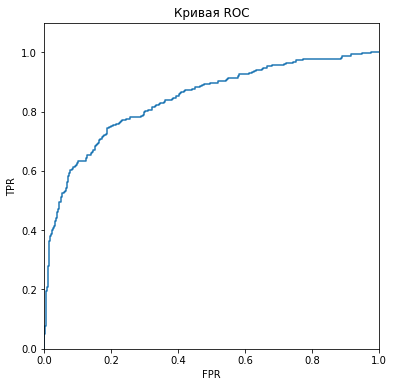

In [29]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid)

print('AUC-ROC =', auc_roc, '- Площадь под графиком.')

plt.figure(figsize=(6, 6))
plt.step(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.1])
plt.xlim([0.0, 1])
plt.title('Кривая ROC')
plt.show() 

#### Вывод

Балансировка классов сильно помогла модели повысить полноту/точность при решении задачи классификации. Для этого мы увеличили долю "положительных" объектов в обучающей выборке.

По "кривой ошибок" видно как сильно наша модель отличается от случайной модели. AUC-ROC равное **0.84** является хорошим показателем качества классификатора.

In [30]:
print('Значение F1-меры выросло на', round(f1 - best_f1, 3), 'и составляет сейчас', f1)

Значение F1-меры выросло на 0.025 и составляет сейчас 0.612167300380228


# Финальное тестирование

Теперь у нас есть обученная модель (`best_model`) с показателем F1 =**0.612**.

Тестирование будем проводить на тестовой (`test`) выборке.

In [31]:
predictions_test = best_model.predict(features_test).tolist()

def error_count(answers, predictions):
    errors = 0
    for i in range (len(answers)):
        if answers[i] != predictions[i]:
            errors += 1
    return errors

errors = error_count(target_test.reset_index(drop=True), predictions_test)

print("Ошибок:", errors, 'из', len(target_test))
print('\nЭто', round(errors*100/len(target_test), 3), '% от тестового набора данных')

Ошибок: 289 из 1819

Это 15.888 % от тестового набора данных


In [32]:
probabilities_test = best_model.predict_proba(features_test)
probabilities_test = probabilities_test[:, 1]

f1 = round(f1_score(target_test, predictions_test), 3)
auc_roc = round(roc_auc_score(target_test, probabilities_test), 3)
precision = round(precision_score(target_test, predictions_test), 3) # Точность
recall = round(recall_score(target_test, predictions_test), 3) # Полнота

print('f1 -', f1, '\nauc_roc -', auc_roc, '\n\nprecision -', precision, '\nrecall -', recall)

f1 - 0.585 
auc_roc - 0.846 

precision - 0.622 
recall - 0.553


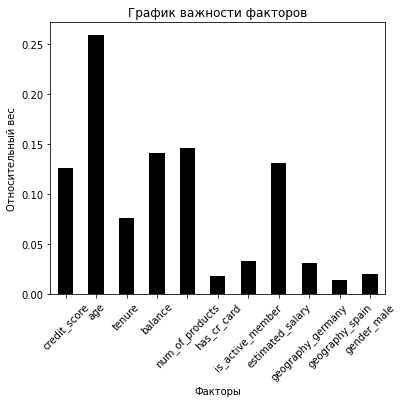

In [33]:
importances = pd.Series(best_model.feature_importances_, index=features_test.columns)

plt.figure(figsize=(6, 5))
importances.plot.bar(color='black', title='График важности факторов', xlabel='Факторы', ylabel='Относительный вес')
plt.xticks(rotation=45)
plt.show()

In [34]:
print('Доля в процентах.')
round(importances.sort_values(ascending=False) * 100, 1)

Доля в процентах.


age                  25.9
num_of_products      14.6
balance              14.2
estimated_salary     13.2
credit_score         12.7
tenure                7.6
is_active_member      3.4
geography_germany     3.2
gender_male           2.1
has_cr_card           1.8
geography_spain       1.4
dtype: float64

Добавим предсказания к признакам тестовой выборки и получим обработанную моделью таблицу. 

In [35]:
features_test_grouped = pd.DataFrame()
features_test['predict'] = predictions_test

# Разделим столбцы на две категории
numeric_list = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
categorial_list = ['has_cr_card', 'is_active_member', 'geography_germany', 'geography_spain', 'gender_male']

# Составляем сгруппированную таблицу
for column in numeric_list:
    features_test_grouped[column] = features_test.groupby('predict')[column].mean()   

for column in categorial_list:
    features_test_grouped[column] = features_test.groupby('predict')[column].sum()

# Добавим недостающий колонки
features_test_grouped.loc[0, 'geography_france'] = len(features_test.query('predict == 0')) - \
    (features_test_grouped.loc[0, 'geography_germany'] + features_test_grouped.loc[0, 'geography_spain'])
features_test_grouped.loc[1, 'geography_france'] = len(features_test.query('predict == 1')) - \
    (features_test_grouped.loc[1, 'geography_germany'] + features_test_grouped.loc[1, 'geography_spain'])

features_test_grouped.loc[0, 'gender_female'] = len(features_test.query('predict == 0')) - \
    features_test_grouped.loc[0, 'gender_male']
features_test_grouped.loc[1, 'gender_female'] = len(features_test.query('predict == 1')) - \
    features_test_grouped.loc[1, 'gender_male']

features_test_grouped.loc[0, 'all_people'] = features_test_grouped.loc[0, 'gender_male'] + \
    features_test_grouped.loc[0, 'gender_female']
features_test_grouped.loc[1, 'all_people'] = features_test_grouped.loc[1, 'gender_male'] + \
    features_test_grouped.loc[1, 'gender_female']

print('Длинна тестовой выборки -', len(features_test))
print('Доля людей, которые предположительно уйдут -', round(features_test_grouped.loc[1, 'all_people'] * 100 / \
                                                            len(features_test), 3), '%')

# Дадим имена классам
features_test_grouped.rename(index={
    0:'Останутся',
    1:'Уйдут'
}, inplace=True)

features_test_grouped

Длинна тестовой выборки - 1819
Доля людей, которые предположительно уйдут - 18.032 %


C:\Users\VINOGR~1\AppData\Local\Temp/ipykernel_52840/2645013249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test['predict'] = predictions_test


,credit_score,age,tenure,balance,num_of_products,estimated_salary,has_cr_card,is_active_member,geography_germany,geography_spain,gender_male,geography_france,gender_female,all_people
predict,,,,,,,,,,,,,,
Останутся,656.928907,36.892689,4.948357,72914.363488,1.552649,98470.521335,1065,849,320.0,398.0,858.0,773.0,633.0,1491.0
Уйдут,651.658537,47.381098,5.167683,84424.489543,1.432927,99171.952957,244,104,154.0,54.0,146.0,120.0,182.0,328.0


Эта таблица очень показательная. Дает достаточное представление о тестовых данных и о предсказаниях.

# Вывод

В нашем распоряжении были данные о **9091** пользователей. Около **909** строк с пропусками в одном из признаков (`tenure`) мы удалили, что бы они не повлияли на нашу дальнейшую работу.

Мы построили модель для задачи классификации, которая прогнозирует, уйдёт клиент из банка в ближайшее время или нет. Была цель добиться показателя F1-меры в **0.59** и больше.

Мы разбили исходные данные на три выборки: тестовую (**20** процентов), валидационную (**20** процентов), обучающую (**60** процентов).

Для решения нашей задачи была выбрана модель Случайного Леса с такими параметрами:

RandomForestClassifier(max_depth=15, n_estimators=50, random_state=12345)

Балансировка классов сильно помогла модели повысить полноту/точность при решении задачи классификации. Для этого мы увеличили долю "положительных" объектов в обучающей выборке.

Итоговое значение F1-меры составило около **0.612**.

По итогу финального тестирования, наша модель ошиблась **289** раз, что составляет примерно **16 %** от числа тестовых данных. 

Было предсказано, что :

- почти **18 %** людей расторгнут договор с банком в близжайшее время. 
- относительно уроженцев других стран, граждане **Франции** преимущественно **не** будут покидать банк.
- доля активных людей (`is_active_member`): **57 %** тех, кто останется; **30 %** тех, кто уйдет.
- доля людей с кредитными картами (`has_cr_card`): **71.5 %** тех, кто останется; **74 %** тех, кто уйдет.
- возраст клиентов, которые по предсказанию уйдут, выше на **10** лет.